[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb)

# Binary classification

## Data loading and preparation

In [1]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [2]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Splitting into train-set and test-set

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

X = data[X_cols] . to_numpy()
y = data[y_cols] . to_numpy() . flatten()
y = ( y == 1 )   # Hodgkin/non-Hodgkin classification

ratio = len(y[y == False]) / len(y[y == True])
print ( "NHL-HL ratio on data-set : {:.1f}%" . format (100 * ratio) )

NHL-HL ratio on data-set : 55.4%


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

### Train-set
ratio_train = len(y_train[y_train == False]) / len(y_train[y_train == True])
print ( "NHL-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == False]) / len(y_test[y_test == True])
print ( "NHL-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

NHL-HL ratio on train-set : 53.8%
NHL-HL ratio on test-set  : 61.5%


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test]

### Train-set
ratio_train = len(y_train[y_train == False]) / len(y_train[y_train == True])
print ( "NHL-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == False]) / len(y_test[y_test == True])
print ( "NHL-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

NHL-HL ratio on train-set : 56.9%
NHL-HL ratio on test-set  : 50.0%


### Data preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = QuantileTransformer (n_quantiles = 50, output_distribution = "normal")

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

np.mean ( X_train, axis = 0 )

array([ 2.27595720e-16,  3.35842465e-16, -2.88657986e-16, -5.55111512e-18,
        5.72458747e-18, -1.21361254e-15, -5.62050406e-16,  6.99440506e-16,
       -1.11924359e-15,  1.98972783e-15, -5.47062395e-15,  8.95117314e-17,
        2.13717932e-16,  6.52256027e-17,  1.30451205e-16, -5.13478149e-17,
       -1.13797860e-16])

## Dummy Classifier

In [7]:
from utils import DummyClassifier, display_score
from sklearn.model_selection import cross_val_score

clf_dummy = DummyClassifier()

accuracy = cross_val_score ( clf_dummy, X_train, y_train, scoring = "accuracy", cv = 3 )
display_score ( scores = accuracy, score_name = "accuracy", model_name = "Dummy Classifier" )

+--------------------+
|  Dummy Classifier  |
+--------------------+
| accuracy : [0.37037037 0.55555556 0.46153846]
| mean : 46.2%
| std  : 7.6%
+--- - -


+---->  Label NHL  <----+
|   Precision : 41.7%   |
|   Recall    : 51.7%   |
+---->  Label HL   <----+
|   Precision : 68.2%   |
|   Recall    : 58.8%   |
+-----------------------+


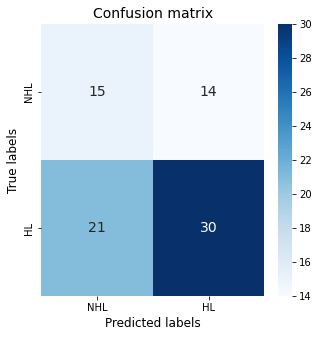

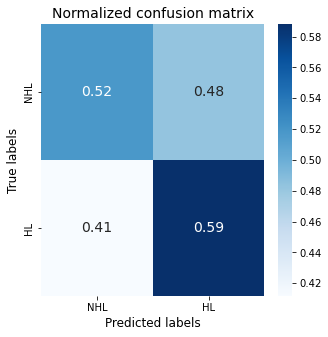

In [8]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3 )

from utils import precision_recall_scores
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Logistic Regression

+-----------------------+
|  Logistic Regression  |
+-----------------------+
| accuracy : [0.81481481 0.62962963 0.61538462]
| mean : 68.7%
| std  : 9.1%
+--- - -
+---->  Label NHL  <----+
|   Precision : 55.6%   |
|   Recall    : 69.0%   |
+---->  Label HL   <----+
|   Precision : 79.5%   |
|   Recall    : 68.6%   |
+-----------------------+


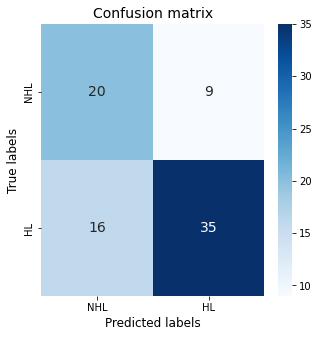

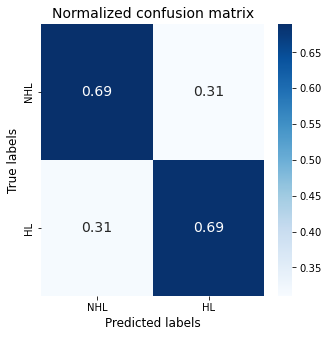

In [9]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = "balanced" ,
                                    solver = "liblinear" ,
                                    max_iter = 500 ,
                                    multi_class = "ovr" ,
                                  )

accuracy = cross_val_score ( clf_logistic, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "Logistic Regression" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [10]:
import optuna
optuna.logging.set_verbosity ( optuna.logging.ERROR )   # silence Optuna during trials study

### Return a set of trials studied by Optuna
def optuna_study (
                   model_name  : str ,
                   storage_dir : str ,
                   objective   : float ,
                   n_trials    : int = 10 ,
                   direction : str = "minimize"  , 
                   load_if_exists : bool = False ,
                 ):
  storage_path = "{}/{}.db" . format (storage_dir, model_name)
  storage_name = "sqlite:///{}" . format (storage_path)  

  if load_if_exists:
    pass
  elif not ( load_if_exists ) and os.path.isfile ( storage_path ):
    os.remove ( storage_path )

  study = optuna.create_study ( 
                                study_name = model_name ,
                                storage  = storage_name ,
                                load_if_exists = load_if_exists ,
                                direction = direction
                              )

  study . optimize ( objective, n_trials = n_trials )

  return study

In [11]:
def obj_logistic (trial):
  c_weights = trial . suggest_categorical ( "c_weights" , [None, "balanced"] )
  solver    = trial . suggest_categorical ( "solver", ["lbfgs", "liblinear"] )
  max_iter  = trial . suggest_int ( "max_iter", 500, 1000, log = True )

  model = LogisticRegression ( 
                               penalty = "l2" ,
                               class_weight = c_weights ,
                               solver = solver ,
                               max_iter = max_iter ,
                               multi_class = "ovr" ,
                             )
  
  y_pred  = cross_val_predict ( model, X_train, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ ratio_train, 1. ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_logistic = optuna_study (
                                model_name  = "bin_clf_logistic"  ,
                                storage_dir = "./storage" ,
                                objective = obj_logistic ,
                                n_trials  = 50 ,
                                direction = "maximize" ,
                                load_if_exists = False ,
                              )

In [12]:
df = study_logistic . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_c_weights,params_max_iter,params_solver,value
41,balanced,872,liblinear,0.68843
42,balanced,952,liblinear,0.68843
22,balanced,912,liblinear,0.68843
21,balanced,917,liblinear,0.68843
4,balanced,542,liblinear,0.68843


+-----------------------+
|  Logistic Regression  |
+-----------------------+
| accuracy : [0.81481481 0.62962963 0.61538462]
| mean : 68.7%
| std  : 9.1%
+--- - -
+---->  Label NHL  <----+
|   Precision : 55.6%   |
|   Recall    : 69.0%   |
+---->  Label HL   <----+
|   Precision : 79.5%   |
|   Recall    : 68.6%   |
+-----------------------+


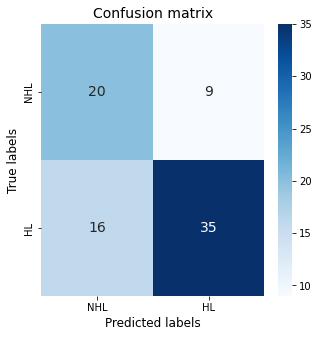

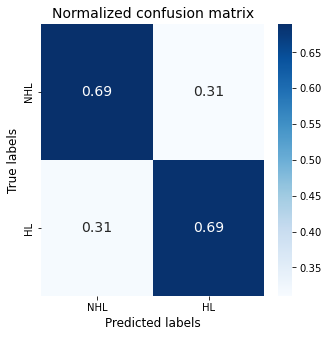

In [13]:
best_params = study_logistic . best_params

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = best_params["c_weights"] ,
                                    solver = best_params["solver"] ,
                                    max_iter = best_params["max_iter"] ,
                                    multi_class = "ovr" ,
                                  )

accuracy = cross_val_score ( clf_logistic, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "Logistic Regression" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

### Features ranking

In [14]:
from sklearn.feature_selection import RFECV

selector = RFECV ( clf_logistic, step = 1, cv = 3 )
selector . fit ( X_train, y_train )

RFECV(cv=3,
      estimator=LogisticRegression(class_weight='balanced', max_iter=542,
                                   multi_class='ovr', solver='liblinear'))

In [15]:
ranks = selector . ranking_
rank1_feats = np.nonzero ( ranks == 1 ) [0]
rank2_feats = np.nonzero ( ranks == 2 ) [0]
rank3_feats = np.nonzero ( ranks == 3 ) [0]
high_ranked_feats = np.concatenate ( [rank1_feats, rank2_feats, rank3_feats] )

print ( "+-------------------+" )
print ( "|  Ranked Features  |" )
print ( "+-------------------+" )
for rnk, feat in zip (ranks, X_cols):
  print ( "| Rank-{:02} : {}" . format (rnk, feat) )
print ( "+--- - -" )

X_train_hrf = X_train [:,high_ranked_feats]
X_test_hrf  = X_test  [:,high_ranked_feats]

+-------------------+
|  Ranked Features  |
+-------------------+
| Rank-08 : age
| Rank-16 : SUVmin (SUV)
| Rank-01 : SUVmean (SUV)
| Rank-07 : MTV (# vx)
| Rank-13 : SMTV (mL/Kg) TOT
| Rank-09 : CONVENTIONAL_SUVbwmin
| Rank-11 : CONVENTIONAL_SUVbwKurtosis
| Rank-03 : DISCRETIZED_HISTO_Kurtosis
| Rank-06 : SHAPE_Sphericity[onlyFor3DROI])
| Rank-15 : GLCM_Correlation
| Rank-17 : GLRLM_SRE
| Rank-04 : NGLDM_Coarseness
| Rank-10 : NGLDM_Busyness
| Rank-12 : GLZLM_LZE
| Rank-14 : GLZLM_LZLGE
| Rank-05 : GLZLM_LZHGE
| Rank-02 : GLZLM_ZLNU
+--- - -


## Random Forest

+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| accuracy : [0.88888889 0.66666667 0.73076923]
| mean : 76.2%
| std  : 9.3%
+--- - -
+---->  Label NHL  <----+
|   Precision : 64.5%   |
|   Recall    : 69.0%   |
+---->  Label HL   <----+
|   Precision : 81.6%   |
|   Recall    : 78.4%   |
+-----------------------+


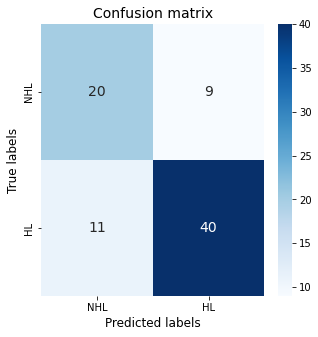

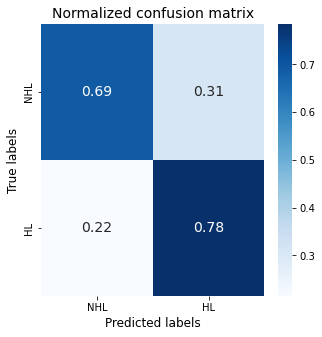

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      criterion = "gini" ,
                                      max_features = "sqrt" ,
                                      max_leaf_nodes = 10 ,
                                      max_depth = 5 ,
                                      class_weight = "balanced" ,
                                    )

accuracy = cross_val_score ( clf_forest, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train_hrf, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "Random Forest Classifier" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [17]:
def obj_forest (trial):
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["gini", "entropy"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )
  c_weights = trial . suggest_categorical ( "c_weights", ["balanced", "balanced_subsample", None] )

  model = RandomForestClassifier ( 
                                   n_estimators = n_estims ,
                                   criterion = criterion   ,
                                   max_features = max_feats  ,
                                   max_leaf_nodes = max_leaf ,
                                   max_depth = max_depth ,
                                   class_weight = c_weights ,
                                 )
  
  y_pred  = cross_val_predict ( model, X_train_hrf, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ ratio_train, 1. ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_forest = optuna_study (
                              model_name  = "bin_clf_forest"  ,
                              storage_dir = "./storage" ,
                              objective = obj_forest ,
                              n_trials  = 50 ,
                              direction = "maximize" ,
                              load_if_exists = False ,
                            )

In [18]:
df = study_forest . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_c_weights,params_criterion,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
22,balanced,entropy,10,log2,4,95,0.819008
11,balanced,entropy,4,log2,2,268,0.804133
41,balanced,entropy,9,log2,4,184,0.760167
1,balanced,gini,3,log2,17,365,0.760167
4,balanced,entropy,9,log2,5,181,0.760167


+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| accuracy : [0.92592593 0.77777778 0.69230769]
| mean : 79.9%
| std  : 9.7%
+--- - -
+---->  Label NHL  <----+
|   Precision : 66.7%   |
|   Recall    : 62.1%   |
+---->  Label HL   <----+
|   Precision : 79.2%   |
|   Recall    : 82.4%   |
+-----------------------+


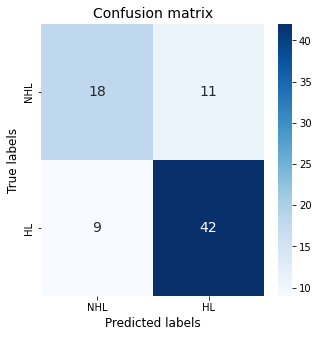

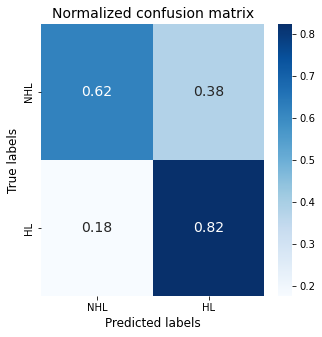

In [19]:
best_params = study_forest . best_params

clf_forest = RandomForestClassifier (
                                      n_estimators = best_params["n_estims"] ,
                                      criterion = best_params["criterion"]   ,
                                      max_features = best_params["max_feats"]  ,
                                      max_leaf_nodes = best_params["max_leaf"] ,
                                      max_depth = best_params["max_depth"] ,
                                      class_weight = best_params["c_weights"] ,
                                    )

accuracy = cross_val_score ( clf_forest, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "Random Forest Classifier" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Gradient Boosted Decision Trees

+-------------------+
|  GBDT Classifier  |
+-------------------+
| accuracy : [0.74074074 0.7037037  0.65384615]
| mean : 69.9%
| std  : 3.6%
+--- - -
+---->  Label NHL  <----+
|   Precision : 51.6%   |
|   Recall    : 55.2%   |
+---->  Label HL   <----+
|   Precision : 73.5%   |
|   Recall    : 70.6%   |
+-----------------------+


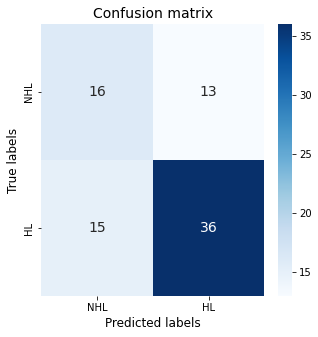

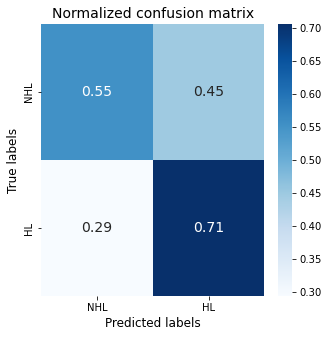

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.3 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        max_features  = None , 
                                        max_leaf_nodes = 10 ,
                                        max_depth = 5       ,
                                      )

accuracy = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "GBDT Classifier" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [21]:
def obj_gbdt (trial):
  loss = trial . suggest_categorical ( "loss", ["deviance", "exponential"] )
  lr   = trial . suggest_float ( "lr", 0.05, 0.95, log = True )
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["friedman_mse", "mse"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = GradientBoostingClassifier ( 
                                       loss = loss ,
                                       learning_rate =  lr , 
                                       n_estimators  =  n_estims , 
                                       criterion  =  criterion   ,
                                       max_features  = max_feats , 
                                       max_leaf_nodes = max_leaf ,
                                       max_depth = max_depth ,
                                     )
  
  y_pred  = cross_val_predict ( model, X_train_hrf, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ ratio_train, 1. ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_gbdt = optuna_study (
                          model_name  = "bin_clf_gbdt"  ,
                          storage_dir = "./storage" ,
                          objective = obj_gbdt ,
                          n_trials  = 50 ,
                          direction = "maximize" ,
                          load_if_exists = False ,
                        )

In [22]:
df = study_gbdt . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_loss,params_lr,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
41,mse,deviance,0.563382,4,None,15,377,0.732395
19,mse,exponential,0.448106,7,None,15,296,0.731077
48,friedman_mse,deviance,0.946968,7,None,10,294,0.725947
34,mse,deviance,0.799462,4,None,13,422,0.725287
16,mse,exponential,0.286968,6,None,12,297,0.723969


+-------------------+
|  GBDT Classifier  |
+-------------------+
| accuracy : [0.7037037  0.66666667 0.57692308]
| mean : 64.9%
| std  : 5.3%
+--- - -
+---->  Label NHL  <----+
|   Precision : 54.8%   |
|   Recall    : 79.3%   |
+---->  Label HL   <----+
|   Precision : 84.2%   |
|   Recall    : 62.7%   |
+-----------------------+


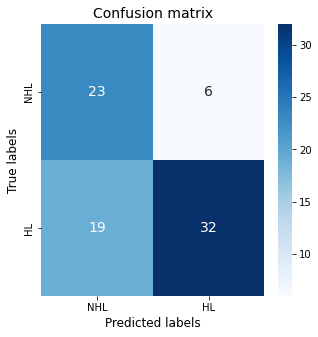

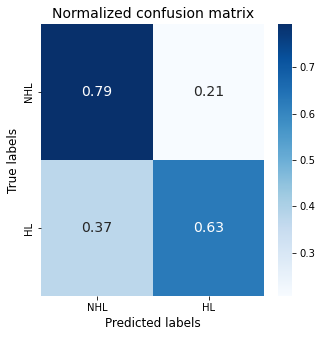

In [23]:
best_params = study_gbdt . best_params

clf_gbdt = GradientBoostingClassifier (
                                        loss = best_params["loss"] ,
                                        learning_rate = best_params["lr"] ,
                                        n_estimators  = best_params["n_estims"]  ,
                                        criterion  =  best_params["criterion"]   ,
                                        max_features  = best_params["max_feats"] ,
                                        max_leaf_nodes = best_params["max_leaf"] ,
                                        max_depth = best_params["max_depth"] ,
                                      )

accuracy = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "GBDT Classifier" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Models combination

+----------------------+
|  Models combination  |
+----------------------+
| accuracy : [0.96296296 0.77777778 0.69230769]
| mean : 81.1%
| std  : 11.3%
+--- - -
+---->  Label NHL  <----+
|   Precision : 71.9%   |
|   Recall    : 79.3%   |
+---->  Label HL   <----+
|   Precision : 87.5%   |
|   Recall    : 82.4%   |
+-----------------------+


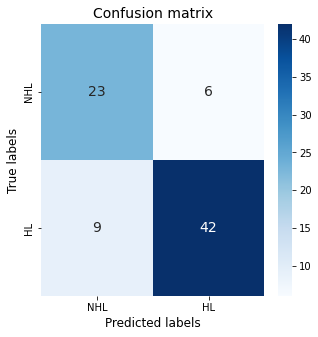

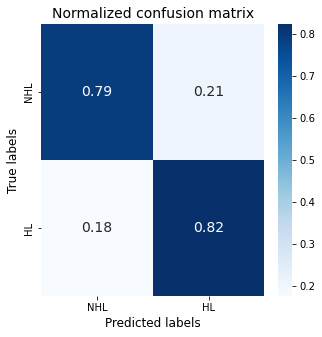

In [24]:
from sklearn.ensemble import VotingClassifier

clf_ens = VotingClassifier (
                             estimators = [ ("logistic", clf_logistic), ("forest", clf_forest), ("GBDT", clf_gbdt) ],
                             voting = "hard"
                           )

accuracy = cross_val_score ( clf_ens, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_ens, X_train_hrf, y_train, cv = 3 )

display_score ( scores = accuracy, score_name = "accuracy", model_name = "Models combination" )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Model evaluation

+---->  Label NHL  <----+
|   Precision : 83.3%   |
|   Recall    : 71.4%   |
+---->  Label HL   <----+
|   Precision : 86.7%   |
|   Recall    : 92.9%   |
+-----------------------+


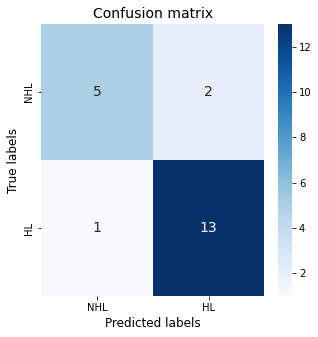

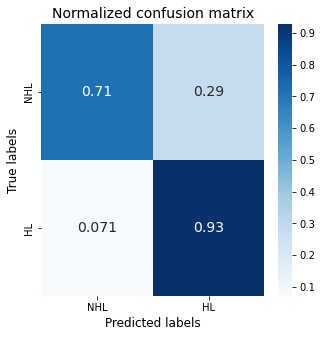

In [25]:
model = clf_ens . fit ( X_train_hrf, y_train )

y_test_pred = model . predict ( X_test_hrf )

_ = precision_recall_scores ( y_test, y_test_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Model export

In [27]:
from datetime import datetime

timestamp = str (datetime.now()) . split (".") [0]
timestamp = timestamp . replace (" ","_")
version = ""
for time, unit in zip ( timestamp.split(":"), ["h","m","s"] ):
  version += time + unit   # YYYY-MM-DD_HHhMMmSSs

model_dir = "./models"
model_name = "bin_clf"
exp_model_file = f"{model_name}_{version}.pkl"
exp_model_path = os.path.join ( model_dir, exp_model_file )

pickle . dump ( model, open ( exp_model_path, "wb" ) )